In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Define the VGG model
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.Linear(1000, 100)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
# Load CIFAR-10 data and apply transformations
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),  # CIFAR-10 images are 32x32
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

trainset = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Training and validation loops
train_losses, val_losses = [], []
train_accs, val_accs = [], []

100%|██████████| 169001437/169001437 [00:03<00:00, 52784439.79it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
from tqdm import tqdm

train_accs, val_accs = [], []

# epoch = 200
epoch = 20

for epoch in range(epoch):
    net.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader, 0)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_accs.append(100.0 * correct / total)

    # Validation
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(testloader))
    val_accs.append(100.0 * correct / total)

    print(
        f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Acc: {train_accs[-1]}, Val Loss: {val_losses[-1]}, Val Acc: {val_accs[-1]}"
    )

100%|██████████| 1563/1563 [00:58<00:00, 26.75it/s]


Epoch 1, Train Loss: 4.606444219710045, Train Acc: 0.994, Val Loss: 4.605298994448238, Val Acc: 1.0


100%|██████████| 1563/1563 [01:00<00:00, 25.91it/s]


Epoch 2, Train Loss: 4.606371818256927, Train Acc: 0.862, Val Loss: 4.6052922425559535, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.87it/s]


Epoch 3, Train Loss: 4.606398431444808, Train Acc: 0.866, Val Loss: 4.605302033713832, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.78it/s]


Epoch 4, Train Loss: 4.60638480024771, Train Acc: 0.888, Val Loss: 4.605290086886373, Val Acc: 1.0


100%|██████████| 1563/1563 [01:00<00:00, 25.93it/s]


Epoch 5, Train Loss: 4.60633254951189, Train Acc: 0.932, Val Loss: 4.60534289241218, Val Acc: 1.0


100%|██████████| 1563/1563 [01:00<00:00, 26.00it/s]


Epoch 6, Train Loss: 4.606391143127656, Train Acc: 0.954, Val Loss: 4.605317766293169, Val Acc: 1.0


100%|██████████| 1563/1563 [01:00<00:00, 25.99it/s]


Epoch 7, Train Loss: 4.606426633479728, Train Acc: 0.898, Val Loss: 4.605277847558165, Val Acc: 1.0


100%|██████████| 1563/1563 [00:59<00:00, 26.35it/s]


Epoch 8, Train Loss: 4.606435804129104, Train Acc: 0.866, Val Loss: 4.605266053074846, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.62it/s]


Epoch 9, Train Loss: 4.606399209699186, Train Acc: 0.92, Val Loss: 4.605308502246015, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.73it/s]


Epoch 10, Train Loss: 4.6063617082719075, Train Acc: 0.938, Val Loss: 4.605310536040284, Val Acc: 1.0


100%|██████████| 1563/1563 [00:59<00:00, 26.41it/s]


Epoch 11, Train Loss: 4.606404815205228, Train Acc: 0.904, Val Loss: 4.605303491647251, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.87it/s]


Epoch 12, Train Loss: 4.60640877115368, Train Acc: 0.942, Val Loss: 4.605287574731504, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.86it/s]


Epoch 13, Train Loss: 4.606420508425585, Train Acc: 0.884, Val Loss: 4.6052666700686125, Val Acc: 1.0


100%|██████████| 1563/1563 [00:57<00:00, 26.96it/s]


Epoch 14, Train Loss: 4.6063928430231424, Train Acc: 0.922, Val Loss: 4.605276517593823, Val Acc: 1.0


100%|██████████| 1563/1563 [00:57<00:00, 26.95it/s]


Epoch 15, Train Loss: 4.606366860126732, Train Acc: 0.892, Val Loss: 4.605319250125093, Val Acc: 1.0


100%|██████████| 1563/1563 [00:57<00:00, 27.20it/s]


Epoch 16, Train Loss: 4.606381777838416, Train Acc: 0.874, Val Loss: 4.605323241541561, Val Acc: 1.0


100%|██████████| 1563/1563 [00:57<00:00, 27.37it/s]


Epoch 17, Train Loss: 4.606421752839385, Train Acc: 0.928, Val Loss: 4.605276252515019, Val Acc: 1.0


100%|██████████| 1563/1563 [00:57<00:00, 27.33it/s]


Epoch 18, Train Loss: 4.6063872594827275, Train Acc: 0.88, Val Loss: 4.605284613161422, Val Acc: 1.0


100%|██████████| 1563/1563 [00:57<00:00, 27.36it/s]


Epoch 19, Train Loss: 4.606410324611652, Train Acc: 0.814, Val Loss: 4.605300268045249, Val Acc: 1.0


100%|██████████| 1563/1563 [00:58<00:00, 26.83it/s]


Epoch 20, Train Loss: 4.606391525695664, Train Acc: 0.87, Val Loss: 4.605294605413565, Val Acc: 1.0


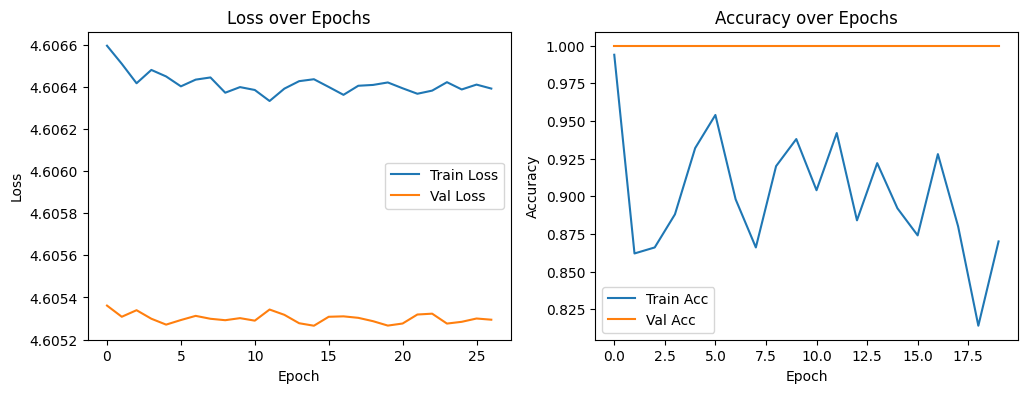

In [6]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")

plt.show()